## Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [5]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.label_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [6]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [8]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [9]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


## Architecture 1: Autoencoder with 1D Time Convolution

### Architecture

Input Data: ( N x C x D x H x W )

In [19]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=800)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 6400)  # Matches shape before Conv1D

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=6400)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)                     # (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}") 
        x = self.conv1d(x)                              # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")      # (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 6400, 1)  
        x = self.deconv1d(x) 
        # print(f"Shape after Deconv1D: {x.shape}")  # (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  

        return z, x_reconstructed


### Training

In [20]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=800)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=6400)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deco

In [21]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50, Train Loss: 0.002687, Test Loss: 0.001898
Epoch 2/50, Train Loss: 0.000655, Test Loss: 0.000844
Epoch 3/50, Train Loss: 0.000389, Test Loss: 0.000672
Epoch 4/50, Train Loss: 0.000300, Test Loss: 0.000289
Epoch 5/50, Train Loss: 0.000249, Test Loss: 0.000348
Epoch 6/50, Train Loss: 0.000234, Test Loss: 0.000303
Epoch 7/50, Train Loss: 0.000221, Test Loss: 0.000429
Epoch 8/50, Train Loss: 0.000220, Test Loss: 0.000223
Epoch 9/50, Train Loss: 0.000205, Test Loss: 0.000215
Epoch 10/50, Train Loss: 0.000201, Test Loss: 0.000818
Epoch 11/50, Train Loss: 0.000258, Test Loss: 0.000352
Epoch 12/50, Train Loss: 0.000174, Test Loss: 0.000195
Epoch 13/50, Train Loss: 0.000171, Test Loss: 0.000246
Epoch 14/50, Train Loss: 0.000160, Test Loss: 0.000258
Epoch 15/50, Train Loss: 0.000158, Test Loss: 0.000330
Epoch 16/50, Train Loss: 0.000152, Test Loss: 0.000231
Epoch 17/50, Train Loss: 0.000152, Test Loss: 0.000407
Epoch 18/50, Train Loss: 0.000151, Test Loss: 0.000164
Epoch 19/50, Train 

### Evaluation

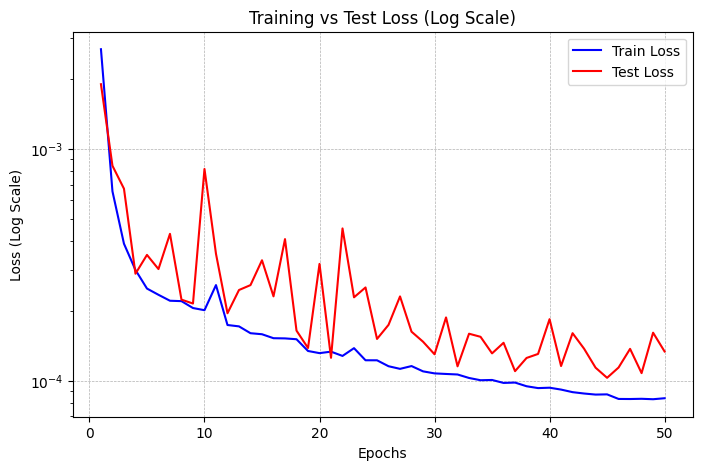

In [22]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [23]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [24]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=21)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [25]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [26]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.4426229508196721
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        26
           1       0.52      0.40      0.45        35

    accuracy                           0.44        61
   macro avg       0.45      0.45      0.44        61
weighted avg       0.46      0.44      0.44        61



Clustering Accuracy

In [27]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:", fmi)

Accuracy: 0.5573770491803278
Precision: [0.48148148 0.61764706]
Recall: [0.5 0.6]
F1-score: [0.49056604 0.60869565]
Fowlkes-Mallows Index: 0.4989130538646512


## Architecture 2: Conv2D Autoencoder with Residual Connections

### Architecture

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2DAutoencoderRes(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoderRes, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions with Residual Connections) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm after conv1
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm after conv2
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm after conv3

        # Skip connections to match dimensions
        self.skip_conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=1, stride=1, padding=0)
        self.skip_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        self.skip_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # BatchNorm after deconv1
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)  # BatchNorm after deconv2
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

        # Skip connections for decoder
        self.skip_conv4 = nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.skip_conv5 = nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)  # Merge time steps into channels (B, C * D, H, W)

        # Residual Block 1
        skip_x = self.skip_conv1(x)  
        x = F.relu(self.bn1(self.conv1(x)))  # Apply BatchNorm and ReLU
        x = x + skip_x  # Residual connection

        # Residual Block 2
        skip_x = self.skip_conv2(x)
        x = F.relu(self.bn2(self.conv2(x)))  # Apply BatchNorm and ReLU
        x = x + skip_x  # Residual connection

        # Residual Block 3
        skip_x = self.skip_conv3(x)
        x = F.relu(self.bn3(self.conv3(x)))  # Apply BatchNorm and ReLU
        x = x + skip_x  # Residual connection

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)

        # Residual Block 4
        skip_x = self.skip_conv4(x)  
        x = F.relu(self.bn4(self.deconv1(x)))  # Apply BatchNorm and ReLU
        x = x + skip_x  # Residual connection

        # Residual Block 5
        skip_x = self.skip_conv5(x)  
        x = F.relu(self.bn5(self.deconv2(x)))  # Apply BatchNorm and ReLU
        x = x + skip_x  # Residual connection

        x = self.deconv3(x)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)

        return z, x_reconstructed


### Training

In [11]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
momentum=0.9
patch_size = config.subpatch_size

model = Conv2DAutoencoderRes(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoderRes(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (skip_conv1): Conv2d(70, 64, kernel_size=(1, 1), stride=(1, 1))
  (skip_conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (skip_conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_featur

In [12]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer='SGD', lr=lr, momentum=momentum, device=device)

Epoch 1/50, Train Loss: 0.025738, Test Loss: 0.005361


Epoch 2/50, Train Loss: 0.004027, Test Loss: 0.003222
Epoch 3/50, Train Loss: 0.002898, Test Loss: 0.002660
Epoch 4/50, Train Loss: 0.002535, Test Loss: 0.002449
Epoch 5/50, Train Loss: 0.002378, Test Loss: 0.002309
Epoch 6/50, Train Loss: 0.002267, Test Loss: 0.002233
Epoch 7/50, Train Loss: 0.002197, Test Loss: 0.002177
Epoch 8/50, Train Loss: 0.002149, Test Loss: 0.002153
Epoch 9/50, Train Loss: 0.002109, Test Loss: 0.002089
Epoch 10/50, Train Loss: 0.002076, Test Loss: 0.002062
Epoch 11/50, Train Loss: 0.002047, Test Loss: 0.002067
Epoch 12/50, Train Loss: 0.002017, Test Loss: 0.002026
Epoch 13/50, Train Loss: 0.001994, Test Loss: 0.001984
Epoch 14/50, Train Loss: 0.001967, Test Loss: 0.001957
Epoch 15/50, Train Loss: 0.001956, Test Loss: 0.001930
Epoch 16/50, Train Loss: 0.001924, Test Loss: 0.001925
Epoch 17/50, Train Loss: 0.001908, Test Loss: 0.001895
Epoch 18/50, Train Loss: 0.001888, Test Loss: 0.001885
Epoch 19/50, Train Loss: 0.001866, Test Loss: 0.001854
Epoch 20/50, Train

### Evaluation

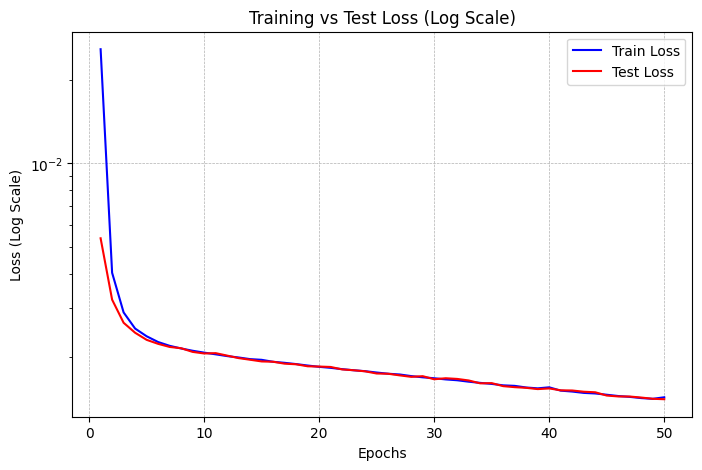

In [13]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [14]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [15]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=29)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [16]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [17]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5901639344262295
              precision    recall  f1-score   support

           0       0.53      0.38      0.44        26
           1       0.62      0.74      0.68        35

    accuracy                           0.59        61
   macro avg       0.57      0.56      0.56        61
weighted avg       0.58      0.59      0.58        61



Clustering Accuracy

In [18]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:", fmi)

Accuracy: 0.5901639344262295
Precision: [0.52631579 0.61904762]
Recall: [0.38461538 0.74285714]
F1-score: [0.44444444 0.67532468]
Fowlkes-Mallows Index: 0.5398237425960825


In [55]:
# with open(config.kmeans_bvi_path, 'wb') as file:
#     pickle.dump(kmeans_bvi, file)

## Architecture 3: Conv2D with Time as Channels

In [31]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Reshape to treat time steps as channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        # Reshape back to spatial dimensions
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed


### Training

In [32]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [33]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50, Train Loss: 0.006874, Test Loss: 0.002026
Epoch 2/50, Train Loss: 0.001633, Test Loss: 0.001402
Epoch 3/50, Train Loss: 0.001197, Test Loss: 0.001099
Epoch 4/50, Train Loss: 0.000909, Test Loss: 0.001051
Epoch 5/50, Train Loss: 0.000751, Test Loss: 0.001057
Epoch 6/50, Train Loss: 0.000720, Test Loss: 0.000777
Epoch 7/50, Train Loss: 0.000682, Test Loss: 0.000848
Epoch 8/50, Train Loss: 0.000623, Test Loss: 0.000603
Epoch 9/50, Train Loss: 0.000537, Test Loss: 0.000626
Epoch 10/50, Train Loss: 0.000476, Test Loss: 0.000736
Epoch 11/50, Train Loss: 0.000433, Test Loss: 0.000828
Epoch 12/50, Train Loss: 0.000421, Test Loss: 0.000669
Epoch 13/50, Train Loss: 0.000370, Test Loss: 0.000382
Epoch 14/50, Train Loss: 0.000341, Test Loss: 0.000366
Epoch 15/50, Train Loss: 0.000329, Test Loss: 0.000507
Epoch 16/50, Train Loss: 0.000318, Test Loss: 0.000436
Epoch 17/50, Train Loss: 0.000292, Test Loss: 0.000288
Epoch 18/50, Train Loss: 0.000265, Test Loss: 0.001059
Epoch 19/50, Train 

### Evaluation

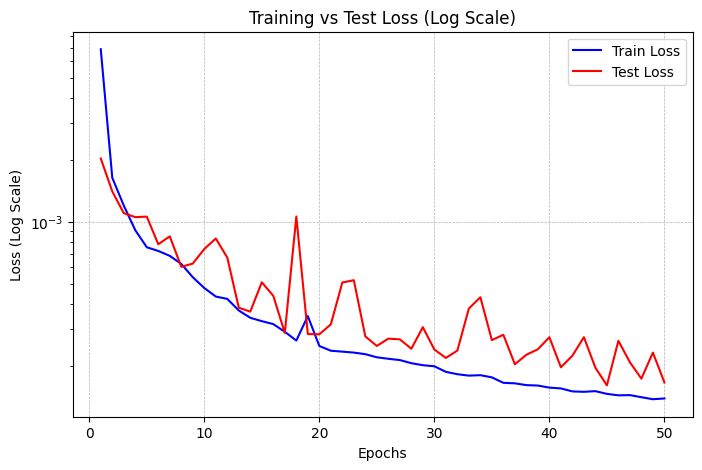

In [34]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [35]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [36]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=22)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [37]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [38]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.4918032786885246
              precision    recall  f1-score   support

           0       0.42      0.54      0.47        26
           1       0.57      0.46      0.51        35

    accuracy                           0.49        61
   macro avg       0.50      0.50      0.49        61
weighted avg       0.51      0.49      0.49        61



Clustering Accuracy

In [40]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallow Index:",fmi)

Accuracy: 0.5081967213114754
Precision: [0.42857143 0.57575758]
Recall: [0.46153846 0.54285714]
F1-score: [0.44444444 0.55882353]
Fowlkes-Mallow Index: 0.49070445570294385


## Architecture 4: Variational Autoencoder

In [58]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)  # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        x = x.view(b, c * h * w, t)
        x = self.conv1d(x)  # Time aggregation

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 256 * patch_size * patch_size, 1)
        x = self.deconv1d(x)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed

### Training

In [59]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kerne

In [60]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 248.6337, Train KL Loss: 10.4550
  Test Recon Loss: 178.0769, Test KL Loss: 12.6095
Epoch 2/50
  Train Recon Loss: 83.3078, Train KL Loss: 12.9338
  Test Recon Loss: 303.5298, Test KL Loss: 14.0313
Epoch 3/50
  Train Recon Loss: 68.5682, Train KL Loss: 13.6600
  Test Recon Loss: 111.2901, Test KL Loss: 14.0020
Epoch 4/50
  Train Recon Loss: 50.1592, Train KL Loss: 13.8234
  Test Recon Loss: 43.6466, Test KL Loss: 13.6903
Epoch 5/50
  Train Recon Loss: 41.8743, Train KL Loss: 13.9301
  Test Recon Loss: 43.6302, Test KL Loss: 13.9449
Epoch 6/50
  Train Recon Loss: 36.7982, Train KL Loss: 14.5489
  Test Recon Loss: 40.3551, Test KL Loss: 14.7596
Epoch 7/50
  Train Recon Loss: 34.3424, Train KL Loss: 15.1435
  Test Recon Loss: 66.0212, Test KL Loss: 15.0713
Epoch 8/50
  Train Recon Loss: 32.7690, Train KL Loss: 15.2295
  Test Recon Loss: 31.1210, Test KL Loss: 14.7357
Epoch 9/50
  Train Recon Loss: 31.6606, Train KL Loss: 15.2569
  Test Recon Loss: 42.8377, T

### Evaluation

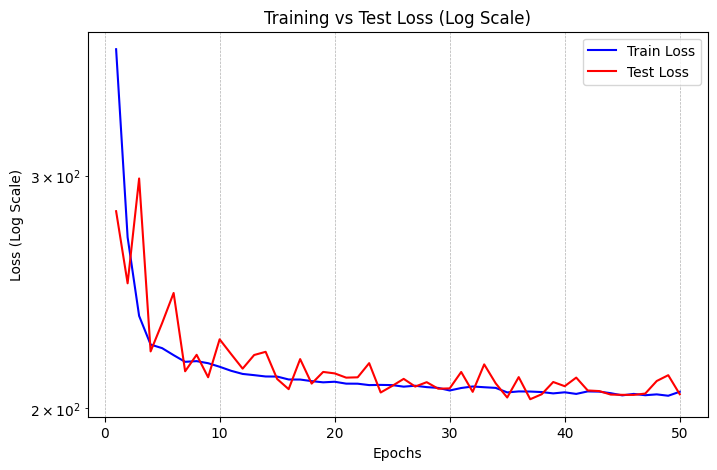

In [ ]:
plot_loss_log_scale(train_recon_losses, test_recon_losses)

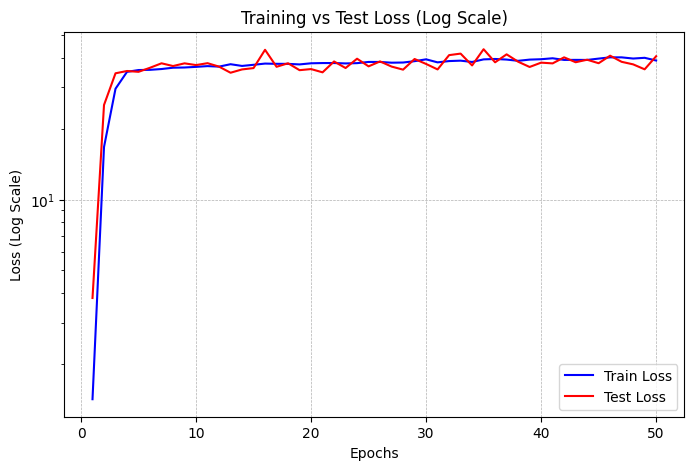

In [ ]:
plot_loss_log_scale(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [ ]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=27)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [ ]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [ ]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5901639344262295
              precision    recall  f1-score   support

           0       0.52      0.46      0.49        26
           1       0.63      0.69      0.66        35

    accuracy                           0.59        61
   macro avg       0.58      0.57      0.57        61
weighted avg       0.58      0.59      0.59        61



Clustering Accuracy

In [17]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:",fmi)

Accuracy: 0.5901639344262295
Precision: [0.52173913 0.63157895]
Recall: [0.46153846 0.68571429]
F1-score: [0.48979592 0.65753425]


## Architecture 5: Variational Autoencoder with time as channels

In [41]:
class Conv2DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)      # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Reshape to treat time steps as channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        # Reshape back to spatial dimensions
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return mu, log_var, z, x_reconstructed

### Training

In [42]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DVAE(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [43]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 381.3005, Train KL Loss: 3.0446
  Test Recon Loss: 206.8776, Test KL Loss: 6.5468
Epoch 2/50
  Train Recon Loss: 190.4122, Train KL Loss: 4.7492
  Test Recon Loss: 184.4594, Test KL Loss: 3.4641
Epoch 3/50
  Train Recon Loss: 169.6471, Train KL Loss: 4.7579
  Test Recon Loss: 147.6901, Test KL Loss: 7.4154
Epoch 4/50
  Train Recon Loss: 130.4203, Train KL Loss: 5.9904
  Test Recon Loss: 135.0137, Test KL Loss: 5.1056
Epoch 5/50
  Train Recon Loss: 106.7258, Train KL Loss: 7.6017
  Test Recon Loss: 100.3548, Test KL Loss: 7.6891
Epoch 6/50
  Train Recon Loss: 91.8751, Train KL Loss: 7.6065
  Test Recon Loss: 95.5101, Test KL Loss: 7.2887
Epoch 7/50
  Train Recon Loss: 89.8857, Train KL Loss: 7.4014
  Test Recon Loss: 95.7251, Test KL Loss: 7.4091
Epoch 8/50
  Train Recon Loss: 87.8203, Train KL Loss: 7.4100
  Test Recon Loss: 88.9095, Test KL Loss: 7.4938
Epoch 9/50
  Train Recon Loss: 85.8924, Train KL Loss: 7.4643
  Test Recon Loss: 91.5430, Test KL Loss

### Evaluation

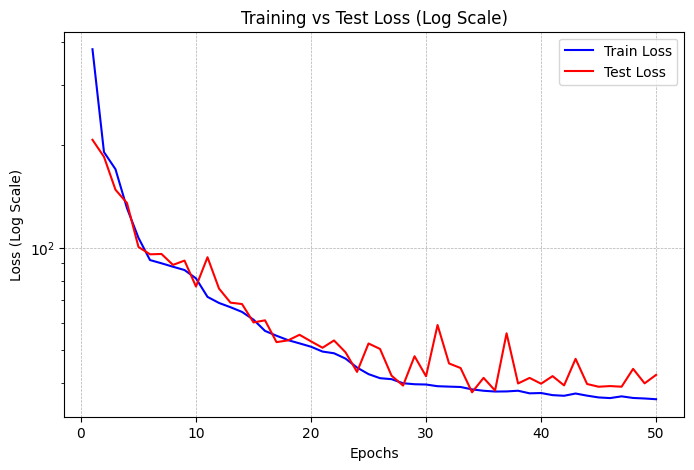

In [51]:
plot_loss_log_scale(train_recon_losses, test_recon_losses)

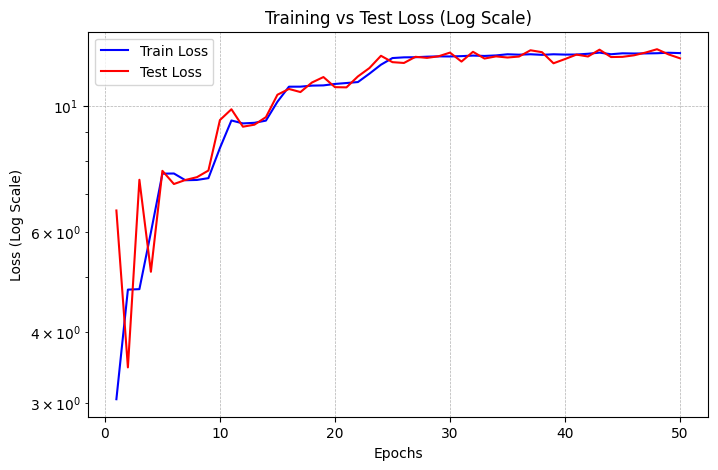

In [52]:
plot_loss_log_scale(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [53]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [54]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=26)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [55]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [56]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.47540983606557374
              precision    recall  f1-score   support

           0       0.31      0.19      0.24        26
           1       0.53      0.69      0.60        35

    accuracy                           0.48        61
   macro avg       0.42      0.44      0.42        61
weighted avg       0.44      0.48      0.45        61



Clustering Accuracy

In [57]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:",fmi)

Accuracy: 0.5245901639344263
Precision: [0.46666667 0.6875    ]
Recall: [0.80769231 0.31428571]
F1-score: [0.5915493  0.43137255]
Fowlkes-Mallows Index: 0.545250654779439


## Final Images: Visualising Diseased Subpatches

In [ ]:
eval_images_box = images_visualisation_eval

In [ ]:
(eval_images_box[0][0].shape)

(64, 64, 13)

In [ ]:
np.unique(eval_images_box[0][0][:,:,-2])

array([      0., 1168039.])

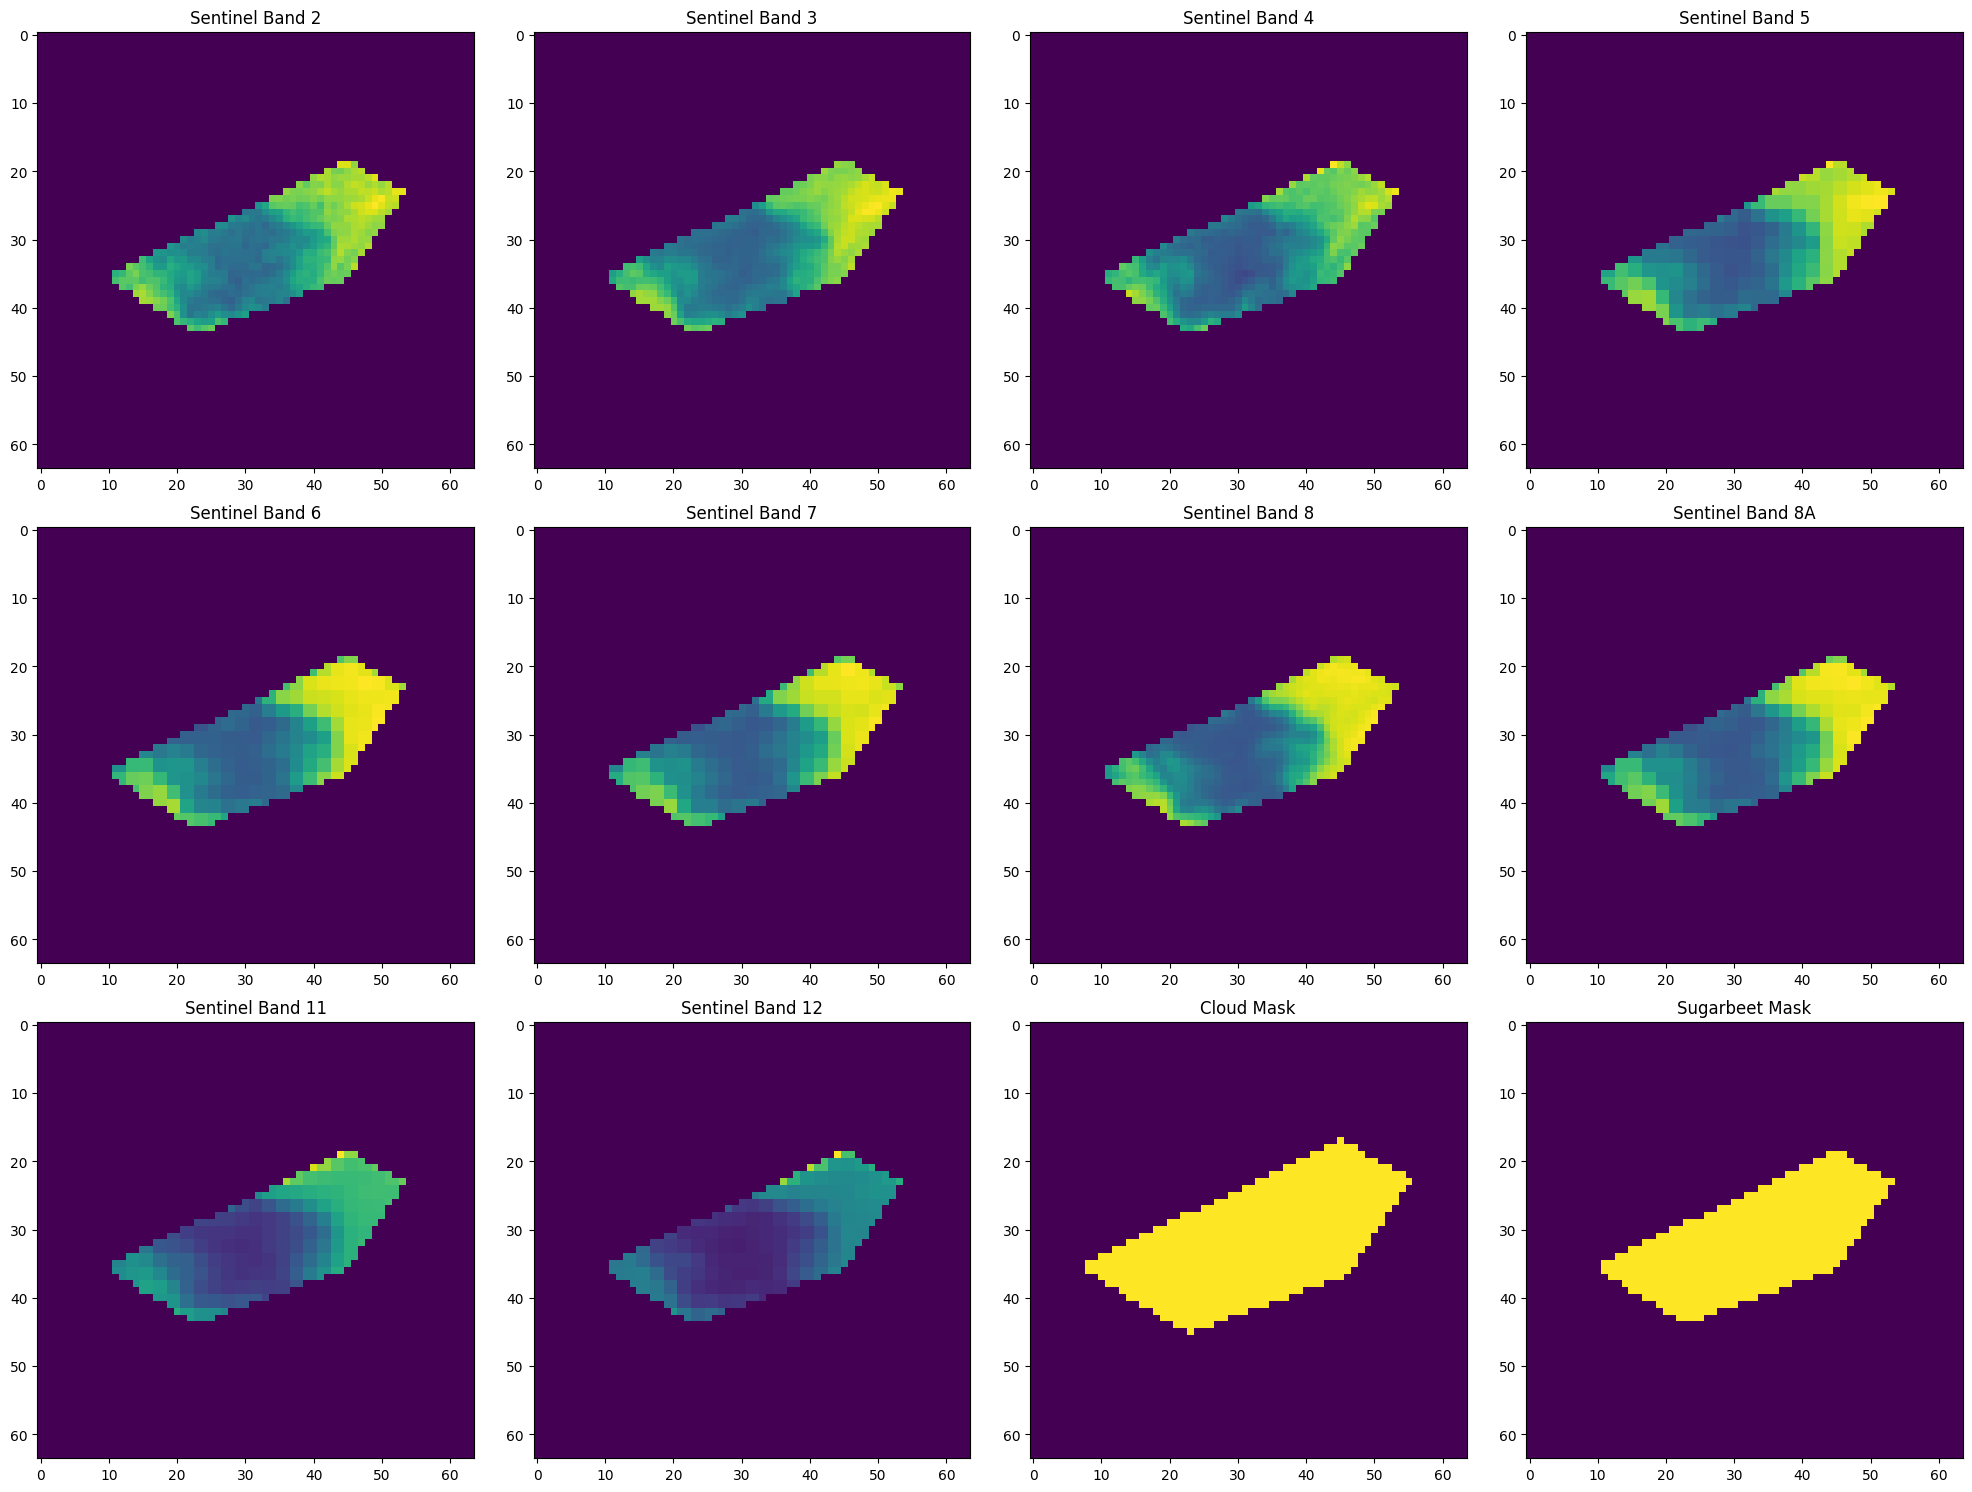

In [ ]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

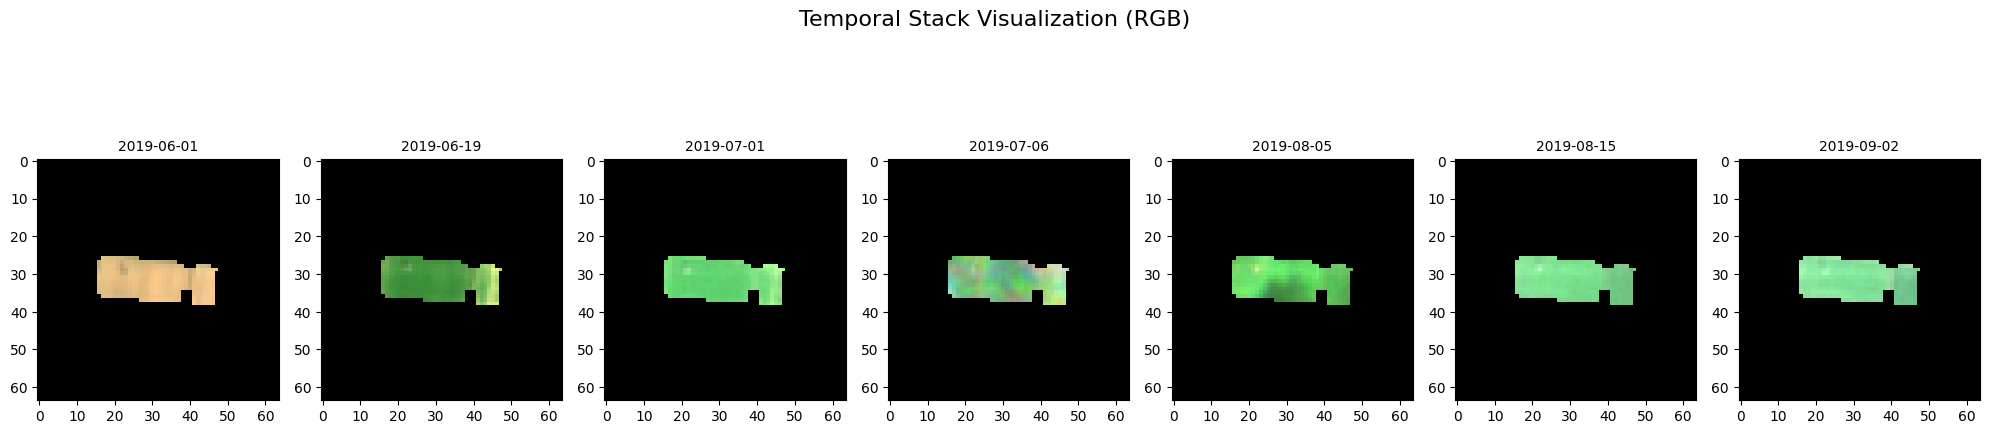

In [ ]:
visualize_temporal_stack_rgb(eval_images_box[-26])

In [ ]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([      0., 1196489., 1196747.])

Saved: /home/k64835/SITS-images/output/img_1168039.png
Saved: /home/k64835/SITS-images/output/img_1228889.png
Saved: /home/k64835/SITS-images/output/img_1168663.png
Saved: /home/k64835/SITS-images/output/img_1168692.png
Saved: /home/k64835/SITS-images/output/img_1171179.png
Saved: /home/k64835/SITS-images/output/img_1172001.png


/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/superpixel.py:257: RuntimeWarning: invalid value encountered in divide
  


Saved: /home/k64835/SITS-images/output/img_1174805.png
Saved: /home/k64835/SITS-images/output/img_1176318.png
Saved: /home/k64835/SITS-images/output/img_1176365.png
Saved: /home/k64835/SITS-images/output/img_1177274.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1178038.png
Saved: /home/k64835/SITS-images/output/img_1178198.png
Saved: /home/k64835/SITS-images/output/img_1179855.png
Saved: /home/k64835/SITS-images/output/img_1182776.png
Saved: /home/k64835/SITS-images/output/img_1182822.png
Saved: /home/k64835/SITS-images/output/img_1183171.png
Saved: /home/k64835/SITS-images/output/img_1194806.png
Saved: /home/k64835/SITS-images/output/img_1196327.png
Saved: /home/k64835/SITS-images/output/img_1196347.png
Saved: /home/k64835/SITS-images/output/img_1196489.png
Saved: /home/k64835/SITS-images/output/img_1216230.png
Saved: /home/k64835/SITS-images/output/img_1216239.png
Saved: /ho

/home/k64835/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


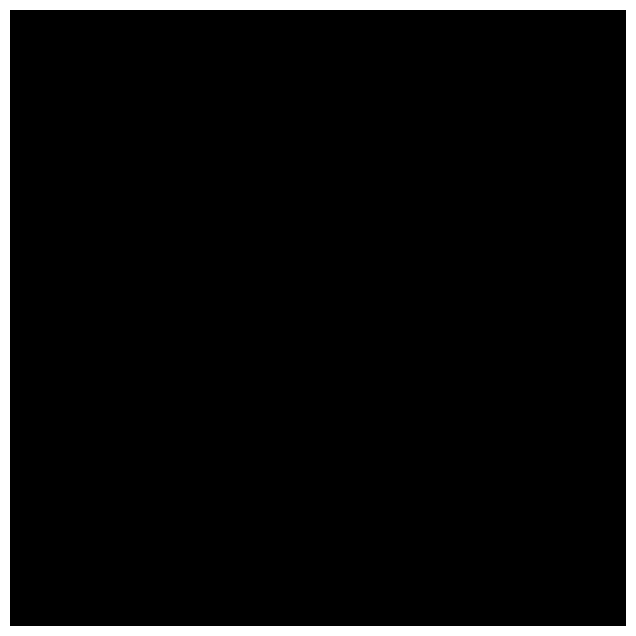

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)